### Data import

Purpose of this notebook is to import and consolidate the monthly, processed CSV files and add in neighborhood

In [100]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import json

In [101]:
# Function to return the neighborhood name given lat / long

def get_neighborhood(lat, long):
    '''
    Accepts lat / long coordinates and returns the name of the neighborhood using reverse geocoding
    Where the neighborhood doesn't exist, fill in these values with np.nan
    '''
    # Instantiate geolocator object
    geolocator = Nominatim(user_agent='citi_bike_share_analysis')
    
    # Format lat and long to pass to reverse geolocator
    loc_string = str(lat) + ', ' + str(long)
    location = geolocator.reverse(loc_string)
    
    # Pull the neighborhood. If no neighborhood listed, then fill with null
    try:
        neighborhood = location.raw['address']['neighbourhood']
    except KeyError:
        neighborhood = np.nan

    # Use this to make sure the function is actually working as intended if needed
#     print(neighborhood)
    
    return neighborhood

In [102]:
# Function to lookup the point in the JSON file and return the neighborhood

def neighborhood_json(point):
    '''
    Function accepts a Point object from the shapely library.
    It parses through the JSON of nyc neighborhood geo data, checking if any of them contain the point.
    If there is a match, the neighborhood name is returned.
    
    '''
    for feature in nycmap['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['ntaname']
            continue

In [128]:
# Function to lookup the point in the JSON file and return the neighborhood

def borough_json(point):
    '''
    This is a repeat of the function above, except to return borough instead of neighborhood.
    
    Function accepts a Point object from the shapely library.
    It parses through the JSON of nyc neighborhood geo data, checking if any of them contain the point.
    If there is a match, the borough name is returned.
    
    '''
    for feature in nycmap['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['boro_name']
            continue

In [103]:
# Read in each CSV and append to the dataframe list

df_list = []
month = 6
year = 2013

for i in range(101):
    
    if month > 12:
        month = 1
        year += 1
    
    if month >= 10:
        df = pd.read_csv(f"./processed/{year}{month}.csv", index_col=0)
        df_list.append(df)

    else:
        df = pd.read_csv(f"./processed/{year}0{month}.csv", index_col=0)
        df_list.append(df)
    
    month += 1

In [104]:
# Concat list of dataframes together

df = pd.concat(df_list)

In [105]:
# Make sure index is a datetime variable

df.index = pd.to_datetime(df.index)
df['year'] = df.index.map(lambda x: x.year)

In [106]:
# Rename columns

df = df.rename(columns={'start station id': 'station_id', 'start station latitude': 'lat', 
                                    'start station longitude': 'long'})

In [107]:
df.head()

,station_id,lat,long,ride_count,year
starttime,,,,,
2013-06-01,72,40.767272,-73.993929,40,2013
2013-06-01,79,40.719116,-74.006667,61,2013
2013-06-01,82,40.711174,-74.000165,6,2013
2013-06-01,83,40.683826,-73.976323,32,2013
2013-06-01,116,40.741776,-74.001497,53,2013


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2144526 entries, 2013-06-01 to 2021-10-31
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   station_id  object 
 1   lat         float64
 2   long        float64
 3   ride_count  int64  
 4   year        int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 98.2+ MB


# NYC neighborhood

- Will test a couple approaches for incorporating neighborhood
- There are two types of outliers found in the coordinate EDA:
    - Stations with 0 lat / long data. The majority of these are for one station where it was just blank in a few instances. The 0s for this station were filled in using the other values. The remaining blanks were dropped.
    - There are a few stations with coordinates up in Montreal (and even with French sounding names?). Not sure how those ended up in teh dataset, but I dropped those as well.
    - Cumulatively, these stations represented only ~200 rides out of ~150mm.

In [109]:
# Find unique set of stations

df_unique = df.drop_duplicates(subset='station_id')

df_stations = df_unique[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

df_stations.info()

# There may be some "duplicate stations" given that the IDs may not be consistently named

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3849 entries, 0 to 3848
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  3849 non-null   object 
 1   lat         3849 non-null   float64
 2   long        3849 non-null   float64
dtypes: float64(2), object(1)
memory usage: 90.3+ KB


In [110]:
df_stations.head()

,station_id,lat,long
0,72,40.767272,-73.993929
1,79,40.719116,-74.006667
2,82,40.711174,-74.000165
3,83,40.683826,-73.976323
4,116,40.741776,-74.001497


In [111]:
# Simplify down to only lat and long

df_lat_long = df_stations[['lat', 'long']]

# Convert to geopandas object

gdf_citibike = gpd.GeoDataFrame(df_lat_long, geometry=gpd.points_from_xy(df_lat_long.long, df_lat_long.lat))

In [112]:
gdf_citibike.head()

,lat,long,geometry
0,40.767272,-73.993929,POINT (-73.99393 40.76727)
1,40.719116,-74.006667,POINT (-74.00667 40.71912)
2,40.711174,-74.000165,POINT (-74.00017 40.71117)
3,40.683826,-73.976323,POINT (-73.97632 40.68383)
4,40.741776,-74.001497,POINT (-74.00150 40.74178)


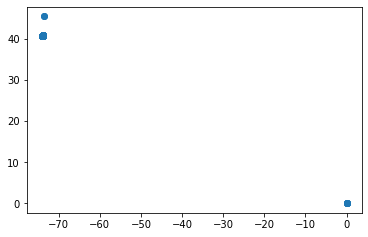

In [113]:
# Plot the stations
# There appears to be two groups of outliers: stations without coordinates and stations that look to be outside NYC
# By Looking 

gdf_citibike.plot();

In [114]:
# Find list of all the outlier station IDs

outlier_coord = df_stations[(df_stations['lat'] >= 42) | (df_stations['lat'] == 0)]

outlier_stations = list(outlier_coord['station_id'])

outlier_stations

[3240, 3446, 3248, 3488, 3633, 3215, 3480, 3650]

In [115]:
# Lookup these null values in the main dataframe
# There are only 2,000 rides that fall under these stations. Not bad, but maybe we can clean it up a bit

outlier_check = df[df['station_id'].isin(outlier_stations)]

outlier_check['ride_count'].sum()

2020

In [116]:
# The majority of outlier stations are because a few of the 3240 stations have blank lat / long (the rest are filled in)
# I will fill these values with the coordinates that appear in the rest of the dataset

display(outlier_check[(outlier_check['station_id'] == 3240) & (outlier_check['lat'] == 0)])
display(outlier_check[outlier_check['station_id'] == 3240].iloc[150:152,:])

,station_id,lat,long,ride_count,year
starttime,,,,,
2016-12-09,3240,0.0,0.0,1,2016
2016-12-23,3240,0.0,0.0,1,2016
2016-12-29,3240,0.0,0.0,1,2016


,station_id,lat,long,ride_count,year
starttime,,,,,
2021-07-18,3240,40.649037,-73.97673,17,2021
2021-07-19,3240,40.649037,-73.97673,23,2021


In [117]:
# Fill in missing values for the 3240 station

df[(df['station_id'] == 3240) & (df['lat'] == 0)] = [3240, 40.649037, -73.976730, 1, 2016]

In [118]:
# Rerun cells above to check new list of outliers
# Find unique set of stations

df_unique = df.drop_duplicates(subset='station_id')

df_stations = df_unique[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

In [119]:
# Find list of all the outlier station IDs
# Only 206 total rides (out of 10s of millions) are associated with stations without an ID

outlier_coord = df_stations[(df_stations['lat'] >= 42) | (df_stations['lat'] == 0)]

outlier_stations = list(outlier_coord['station_id'])

outlier_check = df[df['station_id'].isin(outlier_stations)]

outlier_check['ride_count'].sum()

206

In [120]:
# One final check: these stations with missing lat / long do not have other details we can use to fill it in
# Stations will be dropped from the dataframe

df[df['station_id'].isin(list(df_stations[df_stations['lat'] == 0]['station_id']))]

,station_id,lat,long,ride_count,year
starttime,,,,,
2017-01-30,3446,0.0,0.0,2,2017
2017-06-27,3248,0.0,0.0,2,2017
2017-09-14,3633,0.0,0.0,1,2017
2017-10-01,3215,0.0,0.0,7,2017
2017-10-01,3480,0.0,0.0,17,2017
2017-10-02,3215,0.0,0.0,1,2017
2017-10-02,3480,0.0,0.0,13,2017


In [121]:
# Final dataset will remove remaining stations with 0 coordinates and those with a latitude above 42

df = df[(df['lat'] != 0) & (df['lat'] < 42)]

In [122]:
# Redo the steps above for the final stations

# Find unique set of stations

df_unique = df.drop_duplicates(subset='station_id')

df_stations = df_unique[['station_id', 'lat', 'long']].reset_index().drop('starttime', axis=1)

df_stations.info()

# There may be some "duplicate stations" given that the IDs may not be consistently named

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3842 entries, 0 to 3841
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  3842 non-null   object 
 1   lat         3842 non-null   float64
 2   long        3842 non-null   float64
dtypes: float64(2), object(1)
memory usage: 90.2+ KB


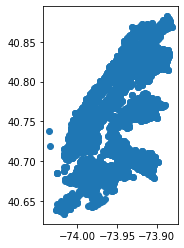

In [123]:
# Simplify down to only lat and long

df_lat_long = df_stations[['lat', 'long']]

# Convert to geopandas object

gdf_citibike = gpd.GeoDataFrame(df_lat_long, geometry=gpd.points_from_xy(df_lat_long.long, df_lat_long.lat))

gdf_citibike.plot();

# Much better! Looks like NYC. There are a couple points that look like they're in New Jersey, but
# the geocoding should take care of those

### Neighborhood: geopy reverse geocoder

- This will leverage Geopy's reverse geocoder functionality
- Based on lat / long, the location object will include the NYC neighborhood

#### Result:

- This library has nice functionality but it produced an unacceptably high number of null values.
- Upon review of these nulls, the geolocation is actually too specific (?) to have a neighborhood tag, i.e., will say 'citibike station at x, y, z location' rather than the neighborhood.

In [124]:
# Test on sample lat /long

geolocator = Nominatim(user_agent='citi_bike_share_analysis')

sample_lat_long = df_stations.loc[0,['lat', 'long']]
lat = sample_lat_long[0]
long = sample_lat_long[1]
combined = str(lat) + ', ' + str(long)
location = geolocator.reverse(combined)
location.raw['address']['neighbourhood']

'Theater District'

In [37]:
# Apply geolocator to every station in the dataset

# df_stations['neighborhood'] = df_stations.apply(lambda row: get_neighborhood(row['lat'], row['long']), axis=1)

In [39]:
# Export neighborhood data to CSV 
# (this ensures we have our worked saved so we don't need to run the previous cell again)

# df_stations.to_csv('./neighborhoods/neighborhood_list.csv')

In [42]:
null_neighborhoods = df_stations[df_stations['neighborhood'].isna()]

### Neighborhood: geo_json

- The below will attempt to map neighborhood to the stations using NYC geo_json data of neighborhoods
- NYC open data publishes geo data, which divides NYC into its main neighborhoods
- By coverting the lat / long to a "point" object, I can search in the JSON for a match and pull in the corresponding neighborhood and borough information.
- This seems to produce the most sensible result vs. reverse geocoding

In [129]:
# Read in JSON map of NYC neighborhoods

nycmap = json.load(open('./nyc_geo_data/2010 Neighborhood Tabulation Areas (NTAs).geojson'))

In [130]:
# Explore structure of JSON
# Each 'feature' has the coordinate map, borough name, and nta_name, which is what we're interested in

nycmap['features'][0]

{'type': 'Feature',
 'properties': {'ntacode': 'QN51',
  'shape_area': '52488277.4492',
  'county_fips': '081',
  'ntaname': 'Murray Hill',
  'shape_leng': '33266.9048559',
  'boro_name': 'Queens',
  'boro_code': '4'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-73.80379022888246, 40.77561011179248],
     [-73.80098974064948, 40.77538911645844],
     [-73.79865192006208, 40.77520055898499],
     [-73.79853009427278, 40.77519072888339],
     [-73.7982329551194, 40.77484830546582],
     [-73.7978540045323, 40.77441566944928],
     [-73.79772190077279, 40.774272373809396],
     [-73.79757522894504, 40.77413684204422],
     [-73.79741530994487, 40.77401038228574],
     [-73.79741522772021, 40.774010319151415],
     [-73.79741514502729, 40.774010265062664],
     [-73.79730005603771, 40.77393228605373],
     [-73.79724339821908, 40.77389389663614],
     [-73.79672685097921, 40.77360922870773],
     [-73.79652490521445, 40.773503278471615],
     [-73.79571707389985, 40.7730696

In [131]:
# Create a 'point' variable column out of the longitute and latitutde

df_stations['point_coordinates'] = df_stations.apply(lambda row: Point(row['long'], row['lat']), axis=1)

df_stations.head()

,station_id,lat,long,point_coordinates
0,72,40.767272,-73.993929,POINT (-73.99392888 40.76727216)
1,79,40.719116,-74.006667,POINT (-74.00666661 40.71911552)
2,82,40.711174,-74.000165,POINT (-74.00016545 40.71117416)
3,83,40.683826,-73.976323,POINT (-73.97632328 40.68382604)
4,116,40.741776,-74.001497,POINT (-74.00149746 40.74177603)


In [132]:
# Apply neighborhood function to the coordinates

df_stations['neighborhood'] = df_stations['point_coordinates'].apply(lambda x: neighborhood_json(x))

In [133]:
# Apply borough function to the coordinates

df_stations['borough'] = df_stations['point_coordinates'].apply(lambda x: borough_json(x))

In [134]:
# Sense check the output

df_stations['borough'].value_counts()

Manhattan    1624
Brooklyn     1092
Bronx         650
Queens        474
Name: borough, dtype: int64

In [135]:
df_stations['neighborhood'].value_counts()

Astoria                                       134
Bushwick South                                130
Hudson Yards-Chelsea-Flatiron-Union Square    114
Midtown-Midtown South                         107
Mott Haven-Port Morris                         94
                                             ... 
park-cemetery-etc-Queens                        9
Bay Ridge                                       8
Kensington-Ocean Parkway                        7
Borough Park                                    2
Flatbush                                        2
Name: neighborhood, Length: 82, dtype: int64

In [137]:
df_stations.head()

,station_id,lat,long,point_coordinates,neighborhood,borough
0,72,40.767272,-73.993929,POINT (-73.99392888 40.76727216),Clinton,Manhattan
1,79,40.719116,-74.006667,POINT (-74.00666661 40.71911552),SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
2,82,40.711174,-74.000165,POINT (-74.00016545 40.71117416),Chinatown,Manhattan
3,83,40.683826,-73.976323,POINT (-73.97632328 40.68382604),Fort Greene,Brooklyn
4,116,40.741776,-74.001497,POINT (-74.00149746 40.74177603),Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan


In [147]:
# Map these stations back to the main dataframe based on station_id
# full_data = full_data.merge(invasive_threat, left_on='Scientific name', right_on='Scientific name', how='left')

df = df.merge(df_stations, left_on='station_id', right_on='station_id', how='left')

df.drop(labels=['lat_y', 'long_y', 'point_coordinates'], axis=1, inplace=True)

df.rename(columns={'lat_x': 'lat', 'long_x': 'long'}, inplace=True)

In [149]:
df.head()

,station_id,lat,long,ride_count,year,neighborhood,borough
0,72,40.767272,-73.993929,40,2013,Clinton,Manhattan
1,79,40.719116,-74.006667,61,2013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
2,82,40.711174,-74.000165,6,2013,Chinatown,Manhattan
3,83,40.683826,-73.976323,32,2013,Fort Greene,Brooklyn
4,116,40.741776,-74.001497,53,2013,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan


In [151]:
# Read to CSV

df.to_csv('./clean_data/clean_ridershare_data.csv', index=False)